In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets

import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml

import torchinfo
from torchinfo import summary

qml.__version__

'0.36.0'

# Setting up a quantum device and hyperparameters:

In [2]:
n_qubits = 4
q_depth = 6
q_delta = 0.005
BATCH_SIZE = 64
epochs = 3
lr_step = 0.0004
dev = qml.device("lightning.gpu", wires = n_qubits)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cuda'

In [4]:
def H_layer(nqubits):
    """
    For assigning hadamard gate on all incoming qubits
    """
    for i in range(nqubits):
        qml.Hadamard(wires = [i])

def RY_layer(phi_elements):
    """
    For assigning RY gate to all incoming qubits, depending on the input phi values, given as an array
    """
    for i, phi in enumerate(phi_elements):
        qml.RY(phi,wires = [i])

def entangling_layer(nqubits):
    """
    It's layers of alternate CNOT's so as to entangle the state of incoming qubits
    """
    for i in range(0,nqubits-1,2):
        qml.CNOT(wires=[i,i+1])
        
    for j in range(1,nqubits-1,2):
        qml.CNOT(wires = [j,j+1])

In [5]:
#Making the quantum net, which will process the qubits to give an output:
@qml.qnode(dev)

def quantum_net(q_input, q_params):

    #Adding the hadamard layer:
    H_layer(n_qubits)

    #Adding the RY layer, according to the input 4 features from the ResNet18 output:
    RY_layer(q_input)

    #Entangling the qubits as well passing them through layers of quantum entanglement and processing:
    for i in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_params[i])

    #Next we will find the expectation value of the qubits in the Z basis by applying a Pauli-Z, so that we can return them as the output:

    val = [qml.expval(qml.Z(wires = [i])) for i in range(n_qubits)]
    return tuple(val)

In [6]:
inp = torch.rand(4)
param = torch.rand(6,4)
quantum_net(inp, param)

(tensor(-0.0375, dtype=torch.float64),
 tensor(-0.3476, dtype=torch.float64),
 tensor(0.0277, dtype=torch.float64),
 tensor(-0.4408, dtype=torch.float64))

In [7]:
#Making the actual quantum block, to process it all:

class Quantum_block(nn.Module):
    def __init__(self):
        super().__init__()

        self.pre_layer = nn.Linear(512,n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth, n_qubits))
        self.post_layer = nn.Linear(n_qubits,2)

    def forward(self, x):
        x = self.pre_layer(x)
        #print(x.shape)
        q_in = x.tanh() * (np.pi/2)
        #print(f"q_in is : {q_in}")
        q_out = torch.tensor([],dtype=torch.float).to(device)
        #print(f"q_out before is: {q_out}")
        
        #going through q_in, passing it through quantum_net, getting the results:
        for element in q_in:
            #print(f"element is {element}")
            #print(f"params : {self.q_params}")
            q_out_elem = torch.tensor(quantum_net(element, self.q_params)).unsqueeze(0).type(torch.float).to(device)
            q_out = torch.cat((q_out,q_out_elem)).type(torch.float).to(device)
            #print(f"q_out is {q_out}")

        #print(f"q_out final is :{q_out}")
        return self.post_layer(q_out)

In [8]:
a=torch.randn(8,512).to(device)
b=Quantum_block().to(device)
b(a)

tensor([[-0.7282,  0.3589],
        [-0.6125,  0.2736],
        [-0.6310,  0.2507],
        [-0.2875,  0.2490],
        [-0.3782, -0.0876],
        [-0.4695,  0.3235],
        [-0.7610,  0.5653],
        [-0.4616,  0.8040]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [9]:
class Residual_Block(nn.Module):
    def __init__(self, 
                 input_channels:int,
                 output_channels:int,
                 stride:int):
        
        super().__init__()

        self.legit = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size = 3, stride = stride, padding = 1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(output_channels, output_channels, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(output_channels),
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or input_channels!=output_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(output_channels),
            )

    def forward(self, x):
        return (self.legit(x) + self.shortcut(x))


class ResNet(nn.Module):
    def __init__(self, Res_Block:nn.Module):
        super().__init__()

        self.in_channels = 64

        self.pre = nn.Sequential(
            nn.Conv2d(3,self.in_channels, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(inplace = True)
        )
        
        self.block_1 = self.make_layer(Res_Block, 64, 2, 1)
        self.block_2 = self.make_layer(Res_Block, 128, 2, 2)
        self.block_3 = self.make_layer(Res_Block, 256, 2, 2)
        self.block_4 = self.make_layer(Res_Block, 512, 2, 2)
        
        self.post = nn.Sequential(
            nn.AvgPool2d(kernel_size=4),
            nn.Flatten(),
        )
        self.final = nn.Linear(512,2)
        

    def make_layer(self, Resblock, channels, num_blocks, stride):
        layers = []
        strides = [stride] + [1]*(num_blocks-1)
        for stride in strides:
            layer = Resblock(self.in_channels, channels, stride)
            self.in_channels = channels
            layers.append(layer)
            
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.final(self.post(self.block_4(self.block_3(self.block_2(self.block_1(self.pre(x)))))))

In [10]:
#Instantiating the model:
quantum_transfer_model = ResNet(Res_Block=Residual_Block).to(device)
print(summary(quantum_transfer_model, [2,3,32,32]))
# a=torch.rand(1,3,32,32)
# print(quantum_transfer_model(a))
# quantum_transfer_model.quantum = Quantum_block()
# quantum_transfer_model(a)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [2, 2]                    --
├─Sequential: 1-1                        [2, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [2, 64, 32, 32]           1,728
│    └─BatchNorm2d: 2-2                  [2, 64, 32, 32]           128
│    └─ReLU: 2-3                         [2, 64, 32, 32]           --
├─Sequential: 1-2                        [2, 64, 32, 32]           --
│    └─Residual_Block: 2-4               [2, 64, 32, 32]           --
│    │    └─Sequential: 3-1              [2, 64, 32, 32]           74,112
│    │    └─Sequential: 3-2              [2, 64, 32, 32]           --
│    └─Residual_Block: 2-5               [2, 64, 32, 32]           --
│    │    └─Sequential: 3-3              [2, 64, 32, 32]           74,112
│    │    └─Sequential: 3-4              [2, 64, 32, 32]           --
├─Sequential: 1-3                        [2, 128, 16, 16]          --
│  

In [11]:
#Creating the data transforms:

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [12]:
train_data = datasets.CIFAR10(root = "CIFAR-10 DATA",
                              train = True,
                              transform=train_transform,
                              download =  True)

test_data = datasets.CIFAR10(root = "CIFAR-10 DATA",
                             train = False,
                             transform=test_transform,
                             download =  True)

train_data, test_data

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: CIFAR-10 DATA
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: CIFAR-10 DATA
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [13]:
train_idx = np.where((np.array(train_data.targets) == 0) | (np.array(train_data.targets) == 1))[0]
test_idx = np.where((np.array(test_data.targets) == 0) | (np.array(test_data.targets) == 1))[0]

train_subset = torch.utils.data.Subset(train_data, train_idx)
test_subset = torch.utils.data.Subset(test_data, test_idx)

train_subset_loader = DataLoader(train_subset, batch_size = 64, shuffle = True, num_workers = 2)
test_subset_loader = DataLoader(test_subset, batch_size = 64, shuffle = False, num_workers = 2)

len(train_subset), len(test_subset)

(10000, 2000)

In [14]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [15]:
# Making a function to view the image:
def view_image(datapoint):
    img,label = datapoint
    plt.figure(figsize = (10,7))
    plt.axis(False)
    plt.title(class_names[label])
    plt.imshow(img.permute(1,2,0))

In [16]:
#Setting up the loss function and optimizer and accuracy :
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = quantum_transfer_model.parameters(), lr = lr_step)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer = optimizer, step_size = 10, gamma = 0.1)
accuracy_fn = Accuracy(task = "binary").to(device)

In [17]:
#Setting up the epochs and timer and the progress bar
def train_model(resnet_model: nn.Module,
                loss_fn:nn.Module,
                train_dataloader:torch.utils.data,
                test_dataloader:torch.utils.data,
                optimizer:torch.optim,
                accuracy_fn = accuracy_fn):
    
    results = {"train_loss" : [],
               "train_acc" : [],
               "test_loss" : [],
               "test_acc" : []}
    from tqdm.auto import tqdm
    from timeit import default_timer as timer
    
    start_timer = timer()
    epochs = 3
    pbar = tqdm(range(epochs), total = epochs)
    for epoch in pbar:
    
        #the training:
        resnet_model.train()
        train_loss, train_acc = 0,0 
        for batch, (X,y) in tqdm(enumerate(train_dataloader), total = len(train_dataloader), desc = "Training", leave=False):
            X,y = X.to(device), y.to(device)
            y_logits = resnet_model(X)
            loss = loss_fn(y_logits, y)
            train_acc += accuracy_fn(y,y_logits.argmax(dim=1))
            train_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        #Update the dictionary:
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        
        
        # print(f"Epoch : {epoch+1}  |  Train Loss : {train_loss:.4f}  |  Train Accuracy : {train_acc*100:.4f}%")
    
        #Testing:
        resnet_model.eval()
        test_loss, test_acc  = 0,0
        with torch.inference_mode():
            for X_test, y_test in tqdm(test_dataloader, total = len(test_dataloader), desc = "Testing", leave=False):
                X_test,y_test = X_test.to(device), y_test.to(device)
                y_test_logits = resnet_model(X_test)
                test_loss += loss_fn(y_test_logits, y_test)
                test_acc += accuracy_fn(y_test, y_test_logits.argmax(dim = 1))
    
            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)
            
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        # print(f"Epoch : {epoch+1}  |  Test Loss : {test_loss:.4f}  |  Test Accuracy : {test_acc*100:.4f}%\n\n")

        pbar.set_description(f"Epoch : {epoch+1} ")
        pbar.set_postfix({"Train Accuracy" : f"{train_acc.item()*100:.4f}%" , "Test Accuracy" : f"{test_acc.item()*100:.4f}%"})
    
    end_timer = timer()
    print(f"Time taken for the model to train is: {end_timer - start_timer:.4f}")
    return results

In [18]:
model_results = train_model(resnet_model = quantum_transfer_model,
                            train_dataloader = train_subset_loader,
                            test_dataloader = test_subset_loader,
                            loss_fn = loss_fn,
                            optimizer = optimizer)
                            

  0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/157 [00:00<?, ?it/s]

Testing:   0%|          | 0/32 [00:00<?, ?it/s]

Training:   0%|          | 0/157 [00:00<?, ?it/s]

Testing:   0%|          | 0/32 [00:00<?, ?it/s]

Training:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f822dda95a0>
Traceback (most recent call last):
  File "/home/sid1729/.cache/pypoetry/virtualenvs/resnet18-c-7ElRw3-py3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/sid1729/.cache/pypoetry/virtualenvs/resnet18-c-7ElRw3-py3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f822dda95a0>
Traceback (most recent call last):
  File "/home/sid1729/.cache/pypoetry/virtualenvs/resnet18-c-7ElRw3-py3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._sh

Testing:   0%|          | 0/32 [00:00<?, ?it/s]

Time taken for the model to train is: 66.3040


In [19]:
summary(quantum_transfer_model, [1,3,32,32])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,728
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
├─Sequential: 1-2                        [1, 64, 32, 32]           --
│    └─Residual_Block: 2-4               [1, 64, 32, 32]           --
│    │    └─Sequential: 3-1              [1, 64, 32, 32]           74,112
│    │    └─Sequential: 3-2              [1, 64, 32, 32]           --
│    └─Residual_Block: 2-5               [1, 64, 32, 32]           --
│    │    └─Sequential: 3-3              [1, 64, 32, 32]           74,112
│    │    └─Sequential: 3-4              [1, 64, 32, 32]           --
├─Sequential: 1-3                        [1, 128, 16, 16]          --
│  

In [20]:
a=torch.rand(1,3,32,32).to(device)
quantum_transfer_model(a)

tensor([[ 2.5601, -2.2408]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [21]:
torch.save(quantum_transfer_model.state_dict(), "Models/resnet_model_binary.pth")
resnet_loaded=ResNet(Res_Block = Residual_Block)
resnet_loaded.load_state_dict(torch.load(f = "Models/resnet_model_binary.pth"))
resnet_loaded.to(device)
def check_accuracy(model:nn.Module, device = device):
    model.to(device)
    model.eval()
    with torch.inference_mode():
        acc = 0
        for x,y in test_subset_loader:
            x,y = x.to(device), y.to(device)
            y_preds = model(x)
            acc += accuracy_fn(y, y_preds.argmax(dim=1))
        acc /= len(test_subset_loader)
    return f"Accuracy of the model is: {acc*100:.4f}%"

check_accuracy(resnet_loaded)

'Accuracy of the model is: 89.9414%'

In [23]:
for params in resnet_loaded.parameters():
    params.requires_grad_(False)

In [24]:
ans = False
for params in resnet_loaded.parameters():
    if (str(params.device) != 'cuda:0'):
        ans=False
        break
    else:
        ans=True
if ans:
   print("cuda:0")
else:
    print("Hell NAWWW")

cuda:0


In [25]:
resnet_loaded.final = Quantum_block()
a=torch.randn(4,3,32,32).to(device)
resnet_loaded = resnet_loaded.to(device)
resnet_loaded(a)

tensor([[ 0.0794, -0.0663],
        [ 0.3521, -0.3493],
        [ 0.2519, -0.2490],
        [-0.1575,  0.1617]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [26]:
quantum_model_results = train_model(resnet_model= resnet_loaded,
                                    loss_fn = loss_fn, 
                                    optimizer = optimizer, 
                                    train_dataloader = train_subset_loader,
                                    test_dataloader = test_subset_loader)

  0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/157 [00:00<?, ?it/s]

Testing:   0%|          | 0/32 [00:00<?, ?it/s]

Training:   0%|          | 0/157 [00:00<?, ?it/s]

Testing:   0%|          | 0/32 [00:00<?, ?it/s]

Training:   0%|          | 0/157 [00:00<?, ?it/s]

Testing:   0%|          | 0/32 [00:00<?, ?it/s]

Time taken for the model to train is: 455.6067


In [27]:
quantum_model_results

{'train_loss': [tensor(0.6571, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6573, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6572, device='cuda:0', grad_fn=<DivBackward0>)],
 'train_acc': [tensor(0.5710, device='cuda:0'),
  tensor(0.5729, device='cuda:0'),
  tensor(0.5744, device='cuda:0')],
 'test_loss': [tensor(0.6484, device='cuda:0'),
  tensor(0.6410, device='cuda:0'),
  tensor(0.6464, device='cuda:0')],
 'test_acc': [tensor(0.5898, device='cuda:0'),
  tensor(0.5933, device='cuda:0'),
  tensor(0.5884, device='cuda:0')]}

In [32]:
# Plotting the progress:
from typing import Dict, List, Tuple
def plot_model_progress(results: Dict[str, List]):
    plt.figure(figsize = (20,20))
    
    plt.subplot(2,1,1)
    plt.plot(range(1,4), torch.tensor(results["train_loss"]), label = "Train loss")
    plt.plot(range(1,4), torch.tensor(results["test_loss"]), label = "Test loss")
    plt.title(f"Train and Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(range(1,4), torch.tensor(results["train_acc"]), label = "Train Accuracy")
    plt.plot(range(1,4), torch.tensor(results["test_acc"]), label = "Test Accuracy")
    plt.title(f"Train and Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (in %)")
    plt.legend()

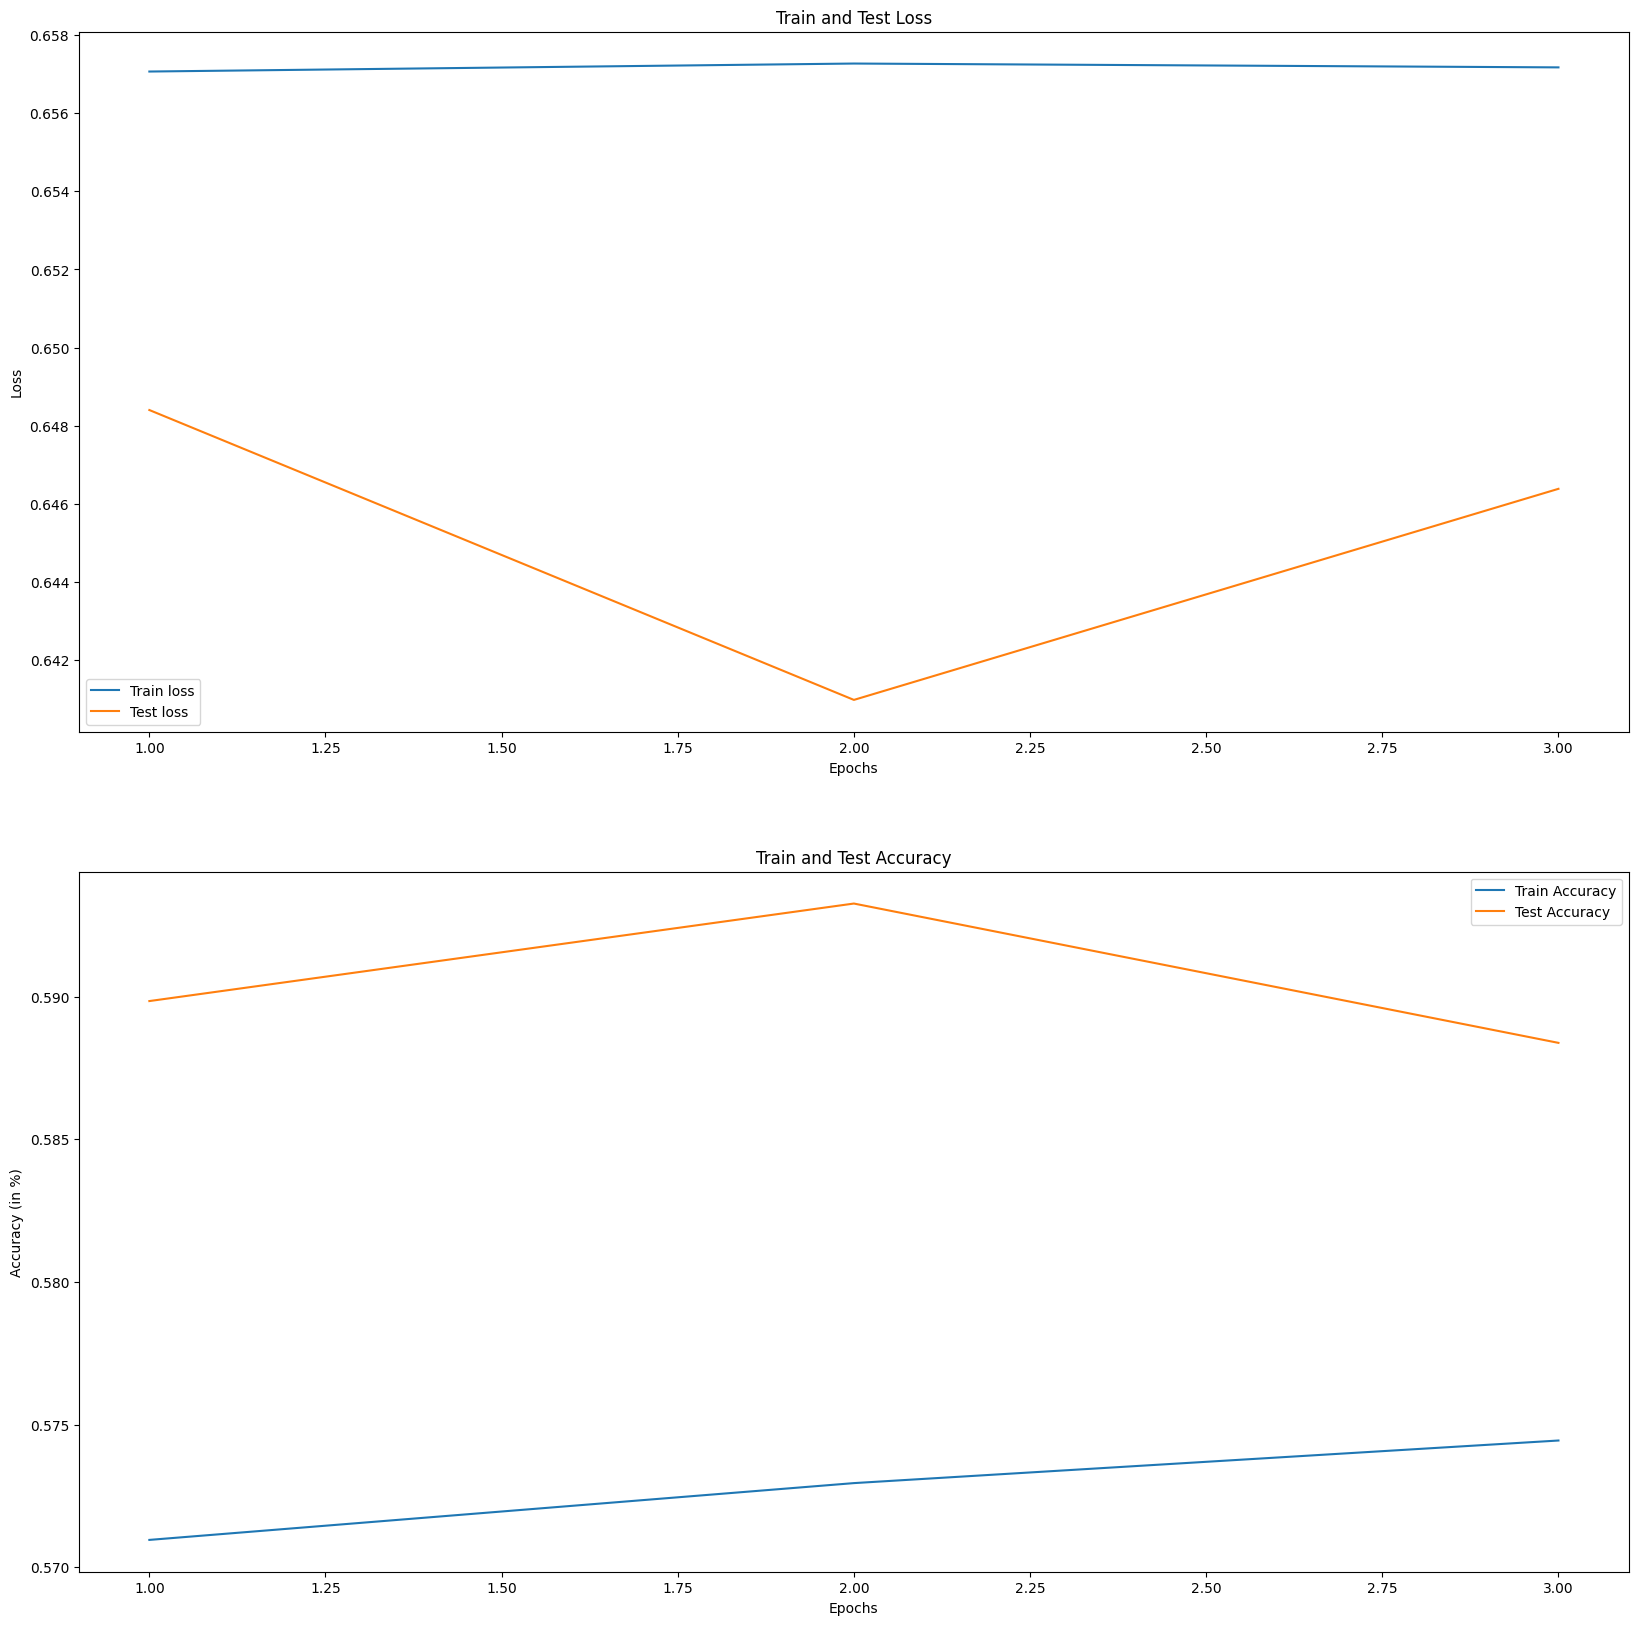

In [33]:
plot_model_progress(quantum_model_results)

In [30]:
t = (1,2,3,4)
a=torch.tensor(t).float().unsqueeze(0)
b=torch.rand(4).float().unsqueeze(0)
c=torch.tensor([])
c = torch.cat((c,a))
c = torch.cat((c,b))
a,b,c

(tensor([[1., 2., 3., 4.]]),
 tensor([[0.7547, 0.3943, 0.3858, 0.0361]]),
 tensor([[1.0000, 2.0000, 3.0000, 4.0000],
         [0.7547, 0.3943, 0.3858, 0.0361]]))

In [31]:
check_accuracy(model = resnet_loaded)

'Accuracy of the model is: 58.8379%'